## ENHANCING DRUG RECOMMENDATION AND SIDE EFFECT AWARENESS THROUGH SENTIMENT ANALYSIS OF CONSUMER REVIEWS

#### Import Required Libraries and Load Dataset

In [ ]:
# Standard libraries
import re
import string
import time
import warnings
from collections import Counter

# Data manipulation and linear algebra
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
import seaborn as sns
import squarify

# Natural Language Processing
import nltk
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

# Deep Learning
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BertForSequenceClassification, BertTokenizer

# Machine Learning
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Interactive tools
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

# Configuration
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

In [2]:
data0 = pd.read_csv('drugLibTrain_raw.tsv',delimiter='\t')
print("Main Data Count:",data0.shape)
data1 = pd.read_csv('drugLibTest_raw.tsv',delimiter='\t')
print("Test Data Count:",data1.shape)

Main Data Count: (3107, 9)
Test Data Count: (1036, 9)


In [3]:
#Merging the 2 datasets
data = pd.concat([data0, data1])

# Rename the column
data.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
data

,ID,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
...,...,...,...,...,...,...,...,...,...
1031,690,accutane,7,Considerably Effective,Severe Side Effects,acne vulgaris,Detoxing effect by pushing out the system thro...,"Hairloss, extreme dry skin, itchiness, raises ...",Treatment period is 3 months/12 weeks. Dosage ...
1032,1071,proair-hfa,10,Highly Effective,No Side Effects,asthma,"The albuterol relieved the constriction, irrit...",I have experienced no side effects.,I use the albuterol as needed because of aller...
1033,681,accutane,8,Considerably Effective,Moderate Side Effects,serve acne,Serve Acne has turned to middle,"Painfull muscles, problems with seeing at night","This drug is highly teratogenic ,females must ..."
1034,2709,divigel,10,Highly Effective,No Side Effects,menopause,"My overall mood, sense of well being, energy l...",No side effects of any kind were noted or appa...,Divigel is a topically applied Bio-Identical H...


#### Dataset Description

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4143 entries, 0 to 1035
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4143 non-null   int64 
 1   urlDrugName        4143 non-null   object
 2   rating             4143 non-null   int64 
 3   effectiveness      4143 non-null   object
 4   sideEffects        4143 non-null   object
 5   condition          4142 non-null   object
 6   benefitsReview     4120 non-null   object
 7   sideEffectsReview  4045 non-null   object
 8   commentsReview     4130 non-null   object
dtypes: int64(2), object(7)
memory usage: 323.7+ KB


In [5]:
# Checking Missing Values
data.isnull().sum()

ID                    0
urlDrugName           0
rating                0
effectiveness         0
sideEffects           0
condition             1
benefitsReview       23
sideEffectsReview    98
commentsReview       13
dtype: int64

In [6]:
#Checking for Duplicate Values
data.duplicated().sum()

0

In [7]:
#Checking Datatypes of values in Columns containing reviews
data_type_counts1 = data["benefitsReview"].apply(type).value_counts()
data_type_counts2 = data["sideEffectsReview"].apply(type).value_counts()
data_type_counts3 = data["commentsReview"].apply(type).value_counts()

print("benefitsReview:\n",data_type_counts1,"\n\nsideEffectsReview:\n",data_type_counts2,"\n\ncommentsReview:\n",data_type_counts3)

#Explicit coversion of column datatype to STRING
data[["benefitsReview","sideEffectsReview","commentsReview"]]=data[["benefitsReview","sideEffectsReview","commentsReview"]].astype(str)

benefitsReview:
 benefitsReview
<class 'str'>      4120
<class 'float'>      23
Name: count, dtype: int64 

sideEffectsReview:
 sideEffectsReview
<class 'str'>      4045
<class 'float'>      98
Name: count, dtype: int64 

commentsReview:
 commentsReview
<class 'str'>      4130
<class 'float'>      13
Name: count, dtype: int64


#### EDA and Data Visualization

##### How many Medications are there?

In [8]:
num = len(data['urlDrugName'].unique().tolist())
print('Number of Medications -',num )

Number of Medications - 541


##### Top 10 Medications

urlDrugName
lexapro       74
paxil         58
retin-a       55
synthroid     53
zoloft        52
prozac        51
effexor       46
effexor-xr    46
chantix       44
accutane      44
Name: count, dtype: int64


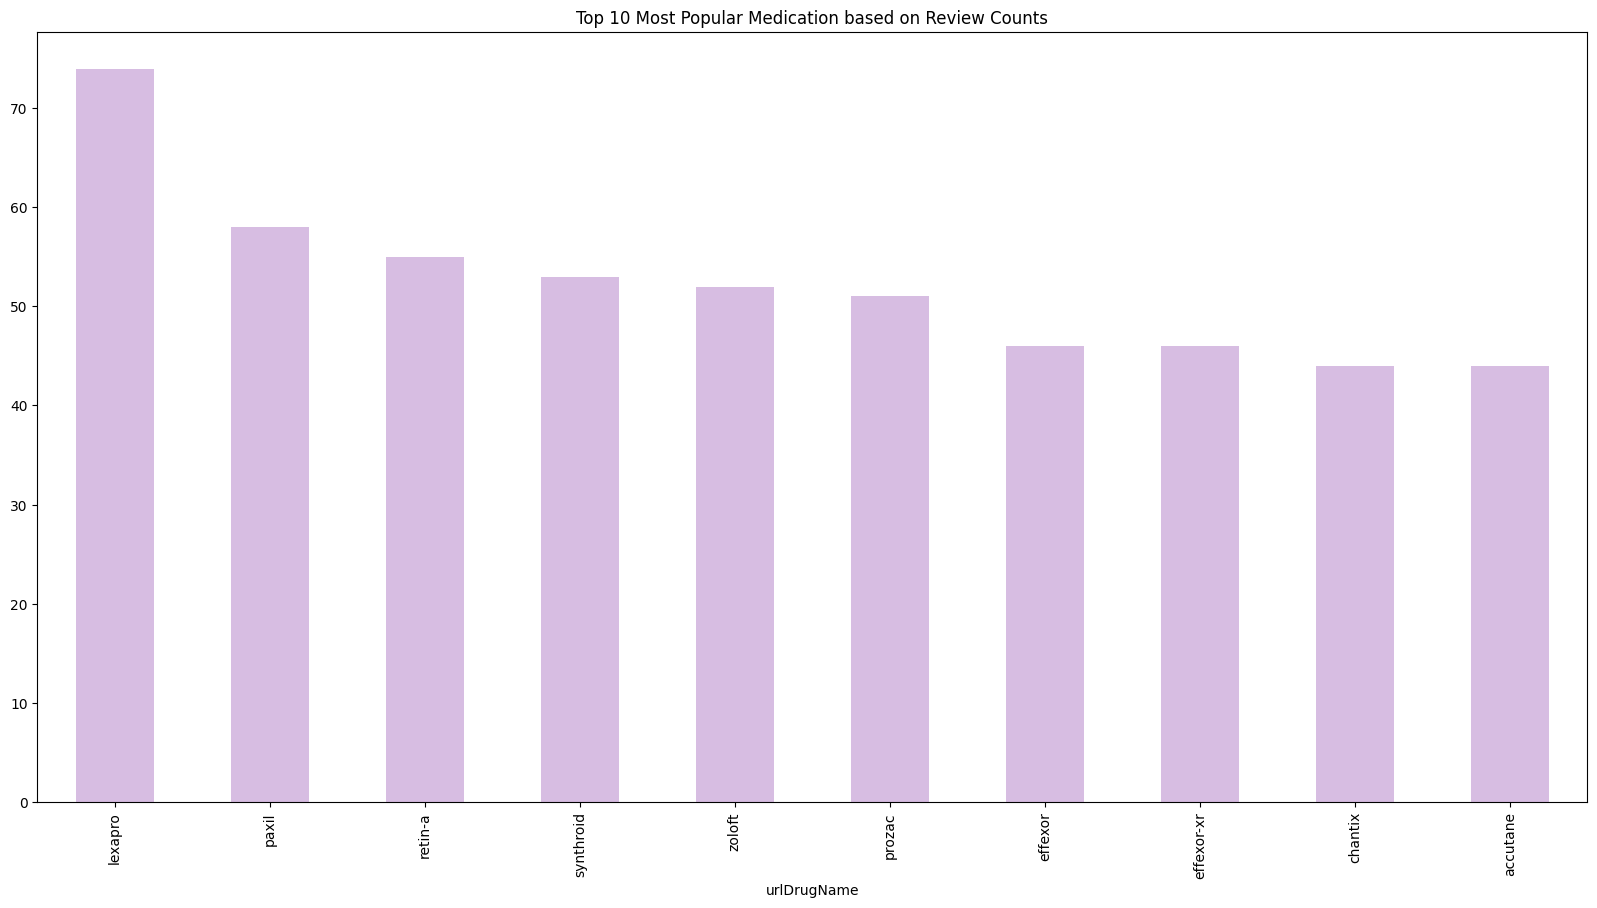

In [9]:
print(data['urlDrugName'].value_counts().nlargest(10))

#Visualization
plt.figure(figsize=(20,10))
data['urlDrugName'].value_counts().nlargest(10).plot(kind='bar',color='#D7BDE2')
plt.title("Top 10 Most Popular Medication based on Review Counts")
plt.show()

##### Suggested Treatments for the Given Condition Along with Review Counts

In [10]:
@interact
def check(condition=widgets.Text(value='', placeholder='Search Condition')):
    
    # Filter data based on the condition
    filtered_data = data[data['condition'].str.contains(condition, case=False, na=False)]
    condition_counts = filtered_data[['urlDrugName','condition']].value_counts().reset_index(name='count')
    
    # Calculate total count for each drug
    total_counts = condition_counts.groupby('urlDrugName')['count'].sum().reset_index()
    total_counts.columns = ['urlDrugName', 'total_count']
    
    # Merge total counts with condition_counts
    condition_counts = pd.merge(condition_counts, total_counts, on='urlDrugName')
    
    # Create a bar chart using Plotly Express
    bar_chart = px.bar(condition_counts, x='urlDrugName', y='count', labels={'count': 'Number of Reviews'},color_discrete_sequence=['#D7BDE2'],)
    
    # Add total count annotations on top of bars
    for drug, total_count in zip(condition_counts['urlDrugName'], condition_counts['total_count']):
        bar_chart.add_trace(go.Scatter(
            x=[drug],
            y=[total_count],
            text=str(total_count),
            mode='text',
            showlegend=False,
            textposition="top center",
            textfont=dict(size=10, color='grey')
        ))
        
    # Remove background color
    bar_chart.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
    
    # Create a table using Plotly graph objects
    table_trace = go.Figure(data=[go.Table(
        header=dict(values=['Drug', 'Condition', 'Count']),
        cells=dict(values=[condition_counts['urlDrugName'], condition_counts['condition'], condition_counts['count']])
    )])
    
    # Display both the bar chart and the table
    bar_chart.show()
    table_trace.show()

interactive(children=(Text(value='', description='condition', placeholder='Search Condition'), Output()), _dom…

##### How many conditions are there?

In [11]:
num = len(data['condition'].unique().tolist())
print('Number of Conditions -',num )

Number of Conditions - 1808


**Disclaimer**: The observation revealed that the conditions associated with medications were not standardized, leading to an imbalance where the count of conditions exceeded that of the drugs. To gain a more comprehensive understanding and draw reliable conclusions, it's essential to use the given below interactive visual representation displaying the list of medications and count of reviews based on the searched condition. This interactive tool allows for a better analysis, enabling researchers and users to make more informed decisions regarding medication choices related to specific health conditions.

#### FOR THESIS
Based on the provided data showing different health conditions and the corresponding counts of reviews associated with those conditions, several insights can be derived:

1. **Prevalence of Conditions:** The most commonly mentioned conditions in the reviews are depression (302 reviews), acne (211 reviews), and anxiety (90 reviews). These conditions appear to be significant concerns among individuals seeking medication-related information.

2. **Mental Health Concerns:** Conditions like depression, anxiety, and ADHD are prevalent, indicating a substantial number of individuals seeking medications and information related to mental health issues. This suggests a societal need for accessible mental health resources and treatments.

3. **Chronic Health Conditions:** Chronic conditions such as high blood pressure (62 reviews), high cholesterol (35 reviews), and hypothyroidism (39 reviews) also have a notable presence. These conditions often require long-term management and may be of concern to a large portion of the population.

4. **Overlap of Conditions:** Some conditions, such as depression/anxiety (26 reviews), indicate overlap or comorbidity between mental health issues. This highlights the complexity of mental health conditions and the need for integrated approaches to treatment and support.

5. **Pain-Related Conditions:** Conditions like migraines (44 reviews), fibromyalgia (29 reviews), and sinus infection (28 reviews) indicate a significant number of individuals dealing with pain-related issues. Effective pain management strategies and medications are essential for improving the quality of life for these individuals.

6. **Gender-Specific Conditions:** Conditions like acne and hair loss might have specific gender-related concerns, and the number of reviews for these conditions could suggest a significant impact on individuals' self-esteem and well-being.

7. **Potential Areas for Research:** Conditions with relatively fewer reviews, such as allergies (49 reviews) and sinus infection (28 reviews), could be areas where more research and information dissemination are needed, as these conditions affect a considerable number of people, but the number of reviews might indicate unmet information needs.

In summary, the data highlights the diverse range of health concerns people face, emphasizing the importance of comprehensive healthcare services, mental health support, and research in various medical domains. Further analysis, including sentiment analysis of the reviews, could provide deeper insights into the experiences and emotions of individuals dealing with these conditions.

##### Top 10 Conditions

condition
depression             302
acne                   211
anxiety                 90
insomnia                75
birth control           68
high blood pressure     62
allergies               49
migraine                44
add                     41
asthma                  41
Name: count, dtype: int64


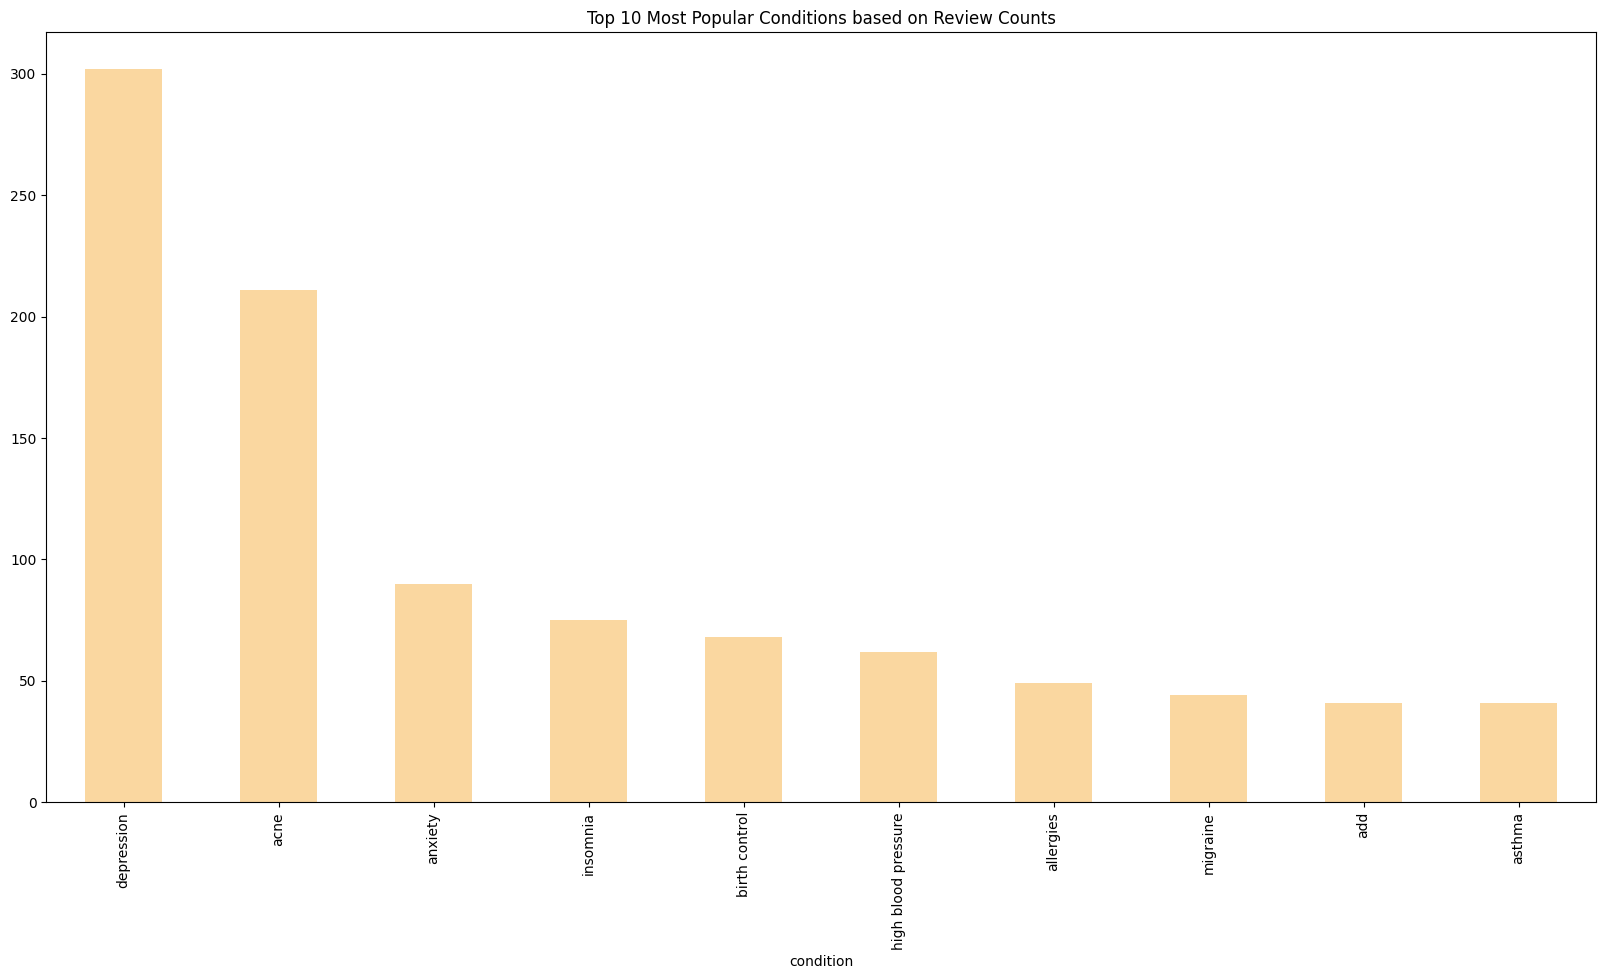

In [12]:
print(data['condition'].value_counts().nlargest(10))
2
#Visualization
plt.figure(figsize=(20,10))
data['condition'].value_counts().nlargest(10).plot(kind='bar',color='#FAD7A0')
plt.title("Top 10 Most Popular Conditions based on Review Counts")
plt.show()

##### Medications and Their Respective Conditions for Treatment

In [13]:
@interact
def check(Drug=list(data['urlDrugName'].value_counts().index)):
    filtered_data = data[data['urlDrugName'] == Drug]
    condition_counts = filtered_data[['condition']].value_counts().reset_index(name='count')
    
    # Calculate total count for each drug
    total_counts = condition_counts.groupby('condition')['count'].sum().reset_index()
    total_counts.columns = ['condition', 'total_count']
    
    # Merge total counts with condition_counts
    condition_counts = pd.merge(condition_counts, total_counts, on='condition')
    
    # Create a bar chart using Plotly Express
    bar_chart = px.bar(condition_counts, x='condition', y='count', labels={'count': 'Number of Reviews'},color_discrete_sequence=['#FAD7A0'],)
    
    # Add total count annotations on top of bars
    for drug, total_count in zip(condition_counts['condition'], condition_counts['total_count']):
        bar_chart.add_trace(go.Scatter(
            x=[drug],
            y=[total_count],
            text=str(total_count),
            mode='text',
            showlegend=False,
            textposition="top center",
            textfont=dict(size=10, color='grey')
        ))
        
    # Remove background color
    bar_chart.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)',height=800)
    
    # Create a table using Plotly graph objects
    table_trace = go.Figure(data=[go.Table(header=dict(values=['Condition', 'Count']),
        cells=dict(values=[condition_counts['condition'], condition_counts['count']]))
    ])
    
    # Display both the bar chart and the table
    bar_chart.show()
    table_trace.show()

interactive(children=(Dropdown(description='Drug', options=('lexapro', 'paxil', 'retin-a', 'synthroid', 'zolof…

##### Rating VS Effectivity

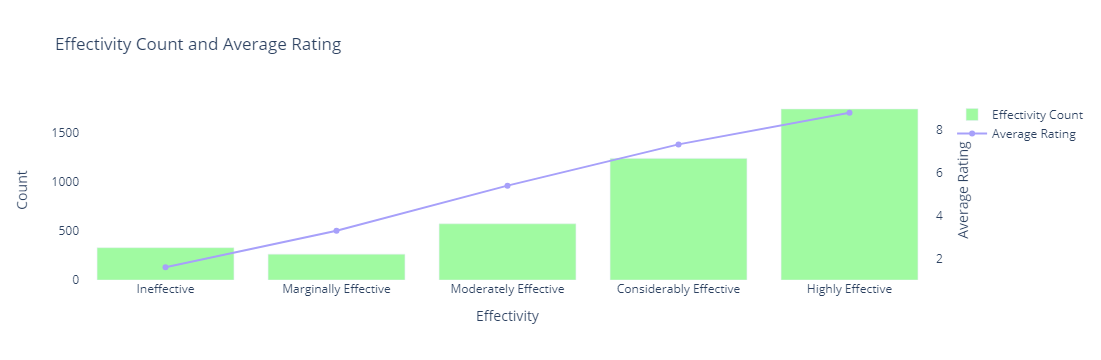

In [14]:
# Define the custom order for x-axis
custom_order = ['Ineffective', 'Marginally Effective', 'Moderately Effective', 'Considerably Effective', 'Highly Effective']

# Calculate count of effectivity levels
effectivity_counts = data['effectiveness'].value_counts().reset_index()
effectivity_counts.columns = ['effectiveness', 'count']

# Calculate average rating for each effectivity level
average_ratings = data.groupby('effectiveness')['rating'].mean().reindex(custom_order).reset_index()

# Create grouped bar chart with two y-axes
fig = go.Figure()

# Add bar trace for effectivity counts (left y-axis)
fig.add_trace(go.Bar(
    x=effectivity_counts['effectiveness'],
    y=effectivity_counts['count'],
    name='Effectivity Count',
    marker_color='#A0FAA1',
    yaxis='y1'  # Assign to the left y-axis
))

# Add line trace for rating (right y-axis)
fig.add_trace(go.Scatter(
    x=average_ratings['effectiveness'],
    y=average_ratings['rating'],
    mode='lines+markers',
    name='Average Rating',
    line=dict(color='#A7A0FA', width=2),
    yaxis='y2'  # Assign to the right y-axis
))

# Customize layout
fig.update_layout(
    title='Effectivity Count and Average Rating',
    xaxis=dict(title='Effectivity', tickvals=custom_order),
    yaxis=dict(title='Count', side='left', showgrid=False),
    yaxis2=dict(title='Average Rating', side='right', overlaying='y1', showgrid=False),
    barmode='group',
    xaxis_categoryorder='array',
    xaxis_categoryarray=custom_order,
    plot_bgcolor='rgba(0,0,0,0)',  # Remove background color
    paper_bgcolor='rgba(0,0,0,0)'  # Remove background color
)


# Show the plot
fig.show()

The examination of the Effectivity Scale ratings unveiled fascinating trends. On average, respondents tended to rate medications as follows:

- Ineffective received the lowest average rating at 1.6.
- Marginally Effective was rated slightly higher, with an average of 3.3.
- Moderately Effective received an average rating of 5.4.
- Considerably Effective had a notably higher average rating of 7.3.
- Highly Effective received the highest average rating at 8.8.

Notably, the majority of the 1741 reviews consistently characterized the medications they assessed as 'Highly Effective.' This indicates a strong inclination toward positive experiences, with users predominantly finding the medications to be highly beneficial.

##### Rating VS Side Effects

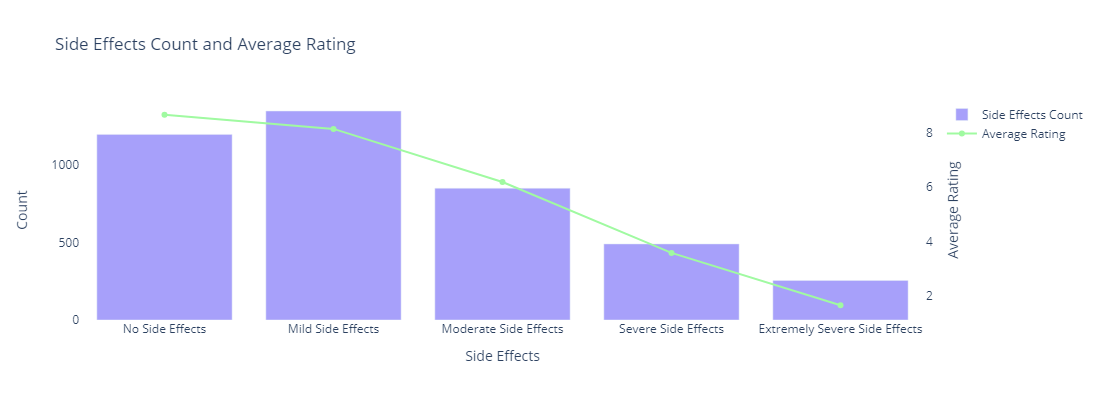

In [15]:
# Define the custom order for x-axis
custom_order = ['No Side Effects','Mild Side Effects','Moderate Side Effects','Severe Side Effects','Extremely Severe Side Effects']

sideEffects_counts = data['sideEffects'].value_counts().reset_index()
sideEffects_counts.columns = ['sideEffects', 'count']

# Calculate average rating for each effectivity level
average_ratings = data.groupby('sideEffects')['rating'].mean().reindex(custom_order).reset_index()

# Create grouped bar chart with two y-axes
fig = go.Figure()

# Add bar trace for effectivity counts (left y-axis)
fig.add_trace(go.Bar(
    x=sideEffects_counts['sideEffects'],
    y=sideEffects_counts['count'],
    name='Side Effects Count',
    marker_color='#A7A0FA',
    yaxis='y1'  # Assign to the left y-axis
))

# Add line trace for rating (right y-axis)
fig.add_trace(go.Scatter(
    x=average_ratings['sideEffects'],
    y=average_ratings['rating'],
    mode='lines+markers',
    name='Average Rating',
    line=dict(color='#A0FAA1', width=2),
    yaxis='y2'  # Assign to the right y-axis
))

# Customize layout
fig.update_layout(
    title='Side Effects Count and Average Rating',
    xaxis=dict(title='Side Effects', tickvals=custom_order),
    yaxis=dict(title='Count', side='left', showgrid=False),
    yaxis2=dict(title='Average Rating', side='right', overlaying='y1', showgrid=False),
    barmode='group',
    xaxis_categoryorder='array',
    xaxis_categoryarray=custom_order,
    plot_bgcolor='rgba(0,0,0,0)',  # Remove background color
    paper_bgcolor='rgba(0,0,0,0)'  # Remove background color
)

fig.update_layout(width=1000, height=400)

# Show the plot
fig.show()


The analysis of the Side Effect Scale ratings uncovered interesting trends. On average, respondents tended to rate medications as follows:

- No Side Effects received the highest average rating at 8.6  
- Mild Side Effects were rated slightly lower, averaging at 8.1  
- Moderate Side Effects had an average rating of 6.2  
- Severe Side Effects received a significantly lower average rating of 3.6  
- Extremely Severe Side Effects had the lowest average rating at 1.7  

Notably, the majority of the 1349 reviews consistently categorized the medications they evaluated as having 'Mild Side Effects'.

##### Effectivity VS Side Effects

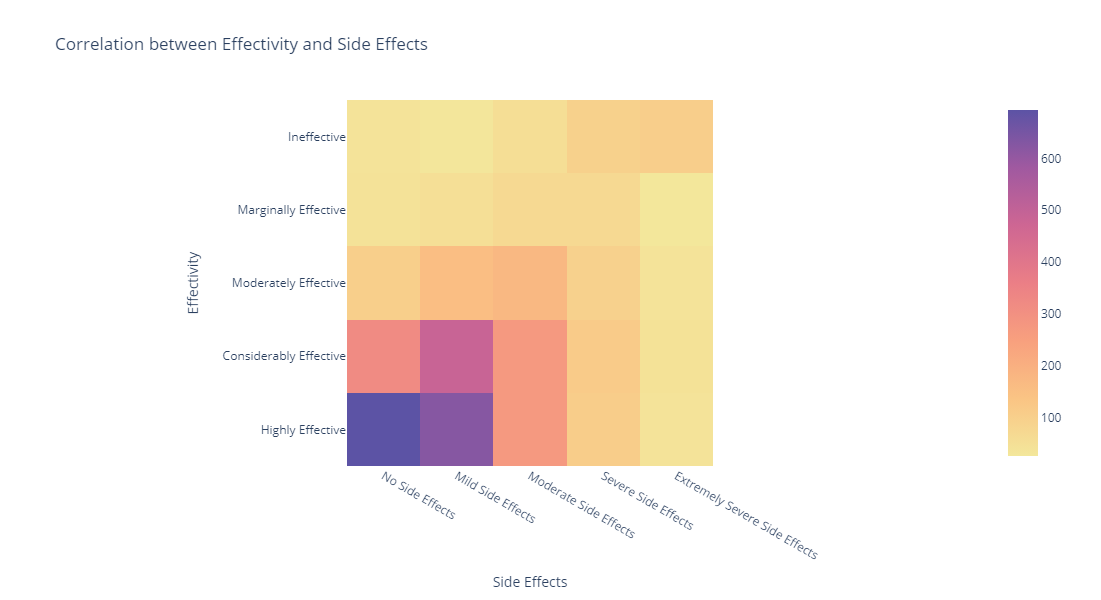

In [16]:
# Define the order of categories for x and y axes
effectivity_order = ['Ineffective', 'Marginally Effective', 'Moderately Effective', 'Considerably Effective', 'Highly Effective']
side_effects_order = ['No Side Effects','Mild Side Effects','Moderate Side Effects','Severe Side Effects','Extremely Severe Side Effects']

# Count the frequency of combinations
heatmap_data = data.groupby(['effectiveness', 'sideEffects']).size().reset_index(name='count')

# Create the heatmap using Plotly Express
fig = px.imshow(
    heatmap_data.pivot(index='effectiveness', columns='sideEffects', values='count').reindex(index=effectivity_order, columns=side_effects_order),
    labels=dict(x='Side Effects', y='Effectivity'),
    x=side_effects_order,
    y=effectivity_order,
    title='Correlation between Effectivity and Side Effects',
    color_continuous_scale='sunset'
)

# Update layout to increase the size of the heatmap
fig.update_layout(width=900, height=600)  # Adjust width and height as needed

# Show the heatmap
fig.show()

#### Sentiment Analysis

In [ ]:
# Models for comparison and the DistilBERT model for averaging
model_names = [
    "emilyalsentzer/Bio_ClinicalBERT",
    "siebert/sentiment-roberta-large-english"
]
distilbert_model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Load the comparison models and tokenizers
models = [AutoModelForSequenceClassification.from_pretrained(name) for name in model_names]
tokenizers = [AutoTokenizer.from_pretrained(name, use_fast=True) for name in model_names]

# Load the DistilBERT model and tokenizer for averaging
distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name)
distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name, use_fast=True)

# Ensure all models are in evaluation mode
for model in models + [distilbert_model]:
    model.eval()

def sentiment_analysis_simple(text, row_number):

    # Text preprocessing
    processed_text = re.sub(r'\d+|[^\w\s]', '', text.lower())

    # Force using CPU
    device = torch.device("cpu")

    def analyze_sentiment(model, tokenizer, review):
        # Prepare inputs
        inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
        
        with torch.no_grad():
            # Get model outputs
            outputs = model(**inputs)
            logits = outputs[0] if isinstance(outputs, tuple) else outputs.logits
            predictions = torch.nn.functional.softmax(logits, dim=-1)
            
            # Assuming index 1 is positive sentiment
            return predictions[:, 1].item()

    # Sequential sentiment analysis for each model and averaging with DistilBERT
    sentiment_scores = []
    for model, tokenizer in zip(models, tokenizers):
        model_score = analyze_sentiment(model, tokenizer, processed_text)
        distilbert_score = analyze_sentiment(distilbert_model, distilbert_tokenizer, processed_text)
        average_score = (model_score + distilbert_score) / 2
        sentiment_scores.append(average_score)

    # Compute final sentiment scores for each averaged pair
    final_sentiment_scores = [(score, 'Positive' if score >= 0.6 else 'Negative' if score <= 0.4 else 'Neutral') for score in sentiment_scores]
    sentiment_scores_str = '; '.join([f"{score:.5f} ({label})" for idx, (score, label) in enumerate(final_sentiment_scores)]);
    
    return sentiment_scores_str

In [ ]:
# Applying the function with row tracking
for index, row in data.iterrows():
    data.at[index, 'benefits_sc'] = sentiment_analysis_simple(row['benefitsReview'], index)

In [ ]:
# Applying the function with row tracking
for index, row in data.iterrows():
    data.at[index, 'sideEffects_sc'] = sentiment_analysis_simple(row['sideEffectsReview'], index)

In [ ]:
# Applying the function with row tracking
for index, row in data.iterrows():
    data.at[index, 'comments_sc'] = sentiment_analysis_simple(row['commentsReview'], index)

In [82]:
# Split 'benfits_sc' and assign to new columns
split_benefit = data['benefits_sc'].str.split(";", expand=True)
data['benefits_model1'] = split_benefit[0]
data['benefits_model2'] = split_benefit[1]

# Split 'sideEffects_sc' and assign to new columns
split_side_effects = data['sideEffects_sc'].str.split(";", expand=True)
data['sideEffects_model1'] = split_side_effects[0]
data['sideEffects_model2'] = split_side_effects[1]

# Split 'comments_sc' and assign to new columns
split_comments = data['comments_sc'].str.split(";", expand=True)
data['comments_model1'] = split_comments[0]
data['comments_model2'] = split_comments[1]

In [83]:
# Assuming 'combined_column' contains values like "0.27761 (Negative)"
pattern = r"(?P<Score>\d+\.\d+)\s\((?P<Label>[A-Za-z]+)\)"

# Extracting the score and label into separate columns
data[['benefits_model1Score', 'benefits_model1Label']] = data['benefits_model1'].str.extract(pattern)

# Extracting for 'benefits_model2'
data[['benefits_model2Score', 'benefits_model2Label']] = data['benefits_model2'].str.extract(pattern)

# Extracting for 'sideEffects_model1'
data[['sideEffects_model1Score', 'sideEffects_model1Label']] = data['sideEffects_model1'].str.extract(pattern)

# Extracting for 'sideEffects_model2'
data[['sideEffects_model2Score', 'sideEffects_model2Label']] = data['sideEffects_model2'].str.extract(pattern)

# Extracting for 'comments_model1'
data[['comments_model1Score', 'comments_model1Label']] = data['comments_model1'].str.extract(pattern)

# Extracting for 'comments_model2'
data[['comments_model2Score', 'comments_model2Label']] = data['comments_model2'].str.extract(pattern)

data['benefits_model1Score'] = pd.to_numeric(data['benefits_model1Score'], errors='coerce')
data['benefits_model2Score'] = pd.to_numeric(data['benefits_model2Score'], errors='coerce')
data['sideEffects_model1Score'] = pd.to_numeric(data['sideEffects_model1Score'], errors='coerce')
data['sideEffects_model2Score'] = pd.to_numeric(data['sideEffects_model2Score'], errors='coerce')
data['comments_model1Score'] = pd.to_numeric(data['comments_model1Score'], errors='coerce')
data['comments_model2Score'] = pd.to_numeric(data['comments_model2Score'], errors='coerce')

In [84]:
data[['benefits_model1Score','benefits_model2Score','sideEffects_model1Score','sideEffects_model2Score','comments_model1Score','comments_model2Score']].describe()

,benefits_model1Score,benefits_model2Score,sideEffects_model1Score,sideEffects_model2Score,comments_model1Score,comments_model2Score
count,4143.000000,4143.000000,4143.000000,4143.000000,4143.000000,4143.000000
mean,0.447136,0.557219,0.312082,0.225111,0.352140,0.411430
std,0.223239,0.342454,0.143182,0.290633,0.174080,0.318641
min,0.154780,0.000350,0.160390,0.000360,0.153130,0.000350
25%,0.262490,0.497880,0.205105,0.002350,0.230295,0.008540
50%,0.363000,0.509520,0.279520,0.008540,0.302470,0.500660
75%,0.682260,0.949880,0.361465,0.500035,0.372805,0.519605
max,0.892490,0.999350,0.875720,0.999340,0.897130,0.999380


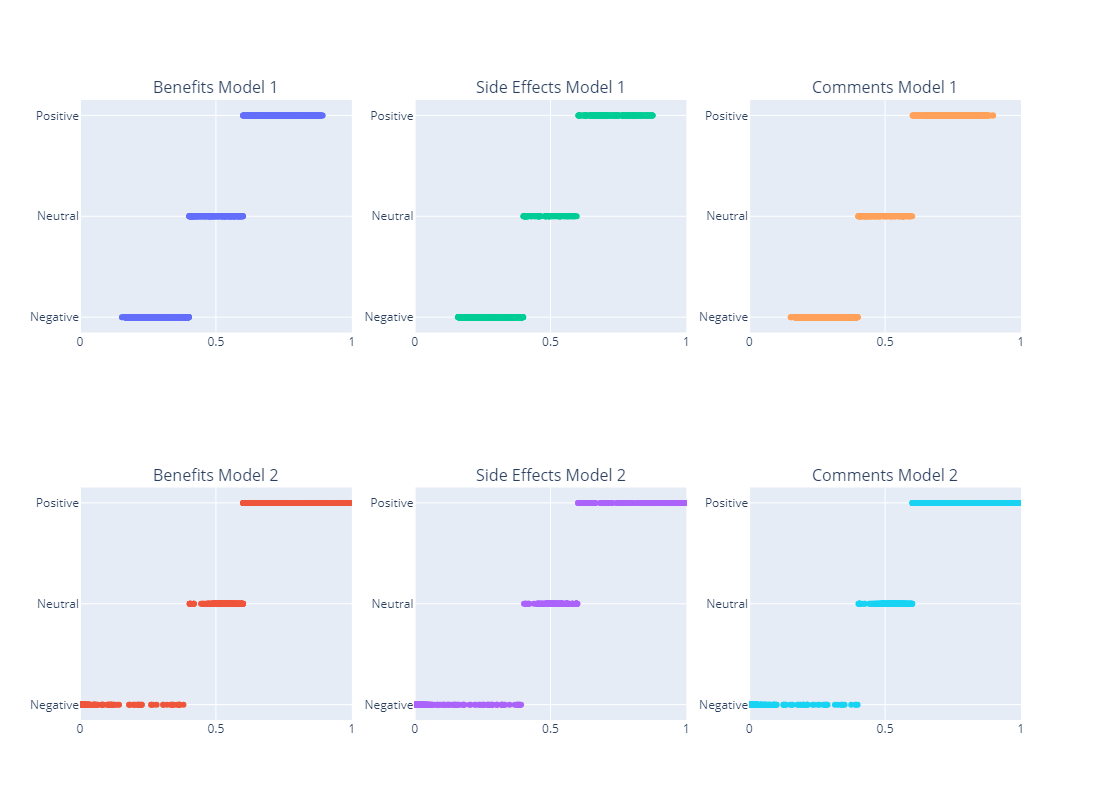

In [85]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Assuming 'data' is your DataFrame and it's already prepared with the necessary columns

# Creating subplots: 3 rows (for benefits, sideEffects, comments), 2 columns (for model1 and model2)
fig = make_subplots(rows=2, cols=3, subplot_titles=("Benefits Model 1",  "Side Effects Model 1", "Comments Model 1",
                                                     "Benefits Model 2","Side Effects Model 2", "Comments Model 2"))

# Adding scatter plots for each model and segment
# Benefits Model 1
fig.add_trace(go.Scatter(x=data['benefits_model1Score'], y=data['benefits_model1Label'], mode='markers', name='Benefits Model 1'),
              row=1, col=1)

# Benefits Model 2
fig.add_trace(go.Scatter(x=data['benefits_model2Score'], y=data['benefits_model2Label'], mode='markers', name='Benefits Model 2'),
              row=2, col=1)

# Side Effects Model 1
fig.add_trace(go.Scatter(x=data['sideEffects_model1Score'], y=data['sideEffects_model1Label'], mode='markers', name='Side Effects Model 1'),
              row=1, col=2)

# Side Effects Model 2
fig.add_trace(go.Scatter(x=data['sideEffects_model2Score'], y=data['sideEffects_model2Label'], mode='markers', name='Side Effects Model 2'),
              row=2, col=2)

# Comments Model 1
fig.add_trace(go.Scatter(x=data['comments_model1Score'], y=data['comments_model1Label'], mode='markers', name='Comments Model 1'),
              row=1, col=3)

# Comments Model 2
fig.add_trace(go.Scatter(x=data['comments_model2Score'], y=data['comments_model2Label'], mode='markers', name='Comments Model 2'),
              row=2, col=3)

# Updating layout for readability
fig.update_layout(height=800, width=1200, showlegend=False)
fig.update_yaxes(categoryorder='category ascending')
# Set x-axis range from 0 to 1 for all subplots
fig.update_xaxes(range=[0, 1])

# Showing the plot
fig.show()

##### Ensemble - Voting Classifier Model

In [86]:
def effectiveness_to_sentiment(eff):
    if eff in ["Highly Effective", "Considerably Effective"]:
        return "Positive"
    elif eff in ["Moderately Effective"]:
        return "Neutral"
    else:
        return "Negative"

def side_effects_to_sentiment(se):
    if se in ["No Side Effects", "Mild Side Effects"]:
        return "Positive"
    elif se in ["Moderate Side Effects"]:
        return "Neutral"
    else:
        return "Negative"

def rating_to_sentiment(rating):
    if rating >= 7:
        return "Positive"
    elif rating <= 3:
        return "Negative"
    else:
        return "Neutral"

# Convert 'effectiveness', 'sideEffects', and 'rating' to sentiments
data['effectiveness_sentiment'] = data['effectiveness'].apply(effectiveness_to_sentiment)
data['sideEffects_sentiment'] = data['sideEffects'].apply(side_effects_to_sentiment)
data['comments_sentiment'] = data['rating'].apply(rating_to_sentiment)

def calculate_accuracy(predicted_labels, actual_labels):
    """Calculate accuracy as the percentage of correct predictions."""
    correct_predictions = predicted_labels == actual_labels
    accuracy = correct_predictions.mean()
    return accuracy

categories = {
    'benefits': 'effectiveness_sentiment',
    'sideEffects': 'sideEffects_sentiment',
    'comments': 'comments_sentiment'
}

# Loop through each category to calculate and print model accuracies
for category, actual_sentiment in categories.items():
    for model in ['model1', 'model2']:
        predicted_sentiment = f'{category}_{model}Label'
        accuracy = calculate_accuracy(data[predicted_sentiment], data[actual_sentiment])
        print(f"Accuracy of {model} for {category}: {accuracy:.2%}")

Accuracy of model1 for benefits: 37.46%
Accuracy of model2 for benefits: 44.22%
Accuracy of model1 for sideEffects: 23.80%
Accuracy of model2 for sideEffects: 23.85%
Accuracy of model1 for comments: 28.05%
Accuracy of model2 for comments: 30.94%


In [123]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Prepare the feature set using model scores
features = pd.DataFrame({
    'benefits_model1Score': data['benefits_model1Score'].astype(float),
    'benefits_model2Score': data['benefits_model2Score'].astype(float),
    'sideEffects_model1Score': data['sideEffects_model1Score'].astype(float),
    'sideEffects_model2Score': data['sideEffects_model2Score'].astype(float),
    'comments_model1Score': data['comments_model1Score'].astype(float),
    'comments_model2Score': data['comments_model2Score'].astype(float)
})

# Define the sentiment categories and their corresponding actual sentiment labels
sentiment_categories = {
    'effectiveness_sentiment': 'Effectiveness',
    'sideEffects_sentiment': 'Side Effects',
    'comments_sentiment': 'Comments'
}

# Initialize the individual classifiers
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
logreg_classifier = LogisticRegression(random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42)

# Create the Voting Classifier with hard voting
voting_clf = VotingClassifier(estimators=[('rf', rf_classifier), ('lr', logreg_classifier), ('dt', dt_classifier)], voting='hard')

# Loop through each sentiment category
for sentiment, name in sentiment_categories.items():
    print(f"\n{name} Sentiment Analysis:")

    # Set the target for the current category
    target = data[sentiment]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Train the Voting Classifier
    voting_clf.fit(X_train, y_train)

    # Make predictions on the testing set
    y_pred = voting_clf.predict(X_test)

    # Calculate and print the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Voting Classifier Accuracy: {accuracy:.2%}")

    # Feature Importances from the Random Forest
    rf_importances = voting_clf.named_estimators_['rf'].feature_importances_
    print("\nRandom Forest Feature Importances:")
    for feature, importance in zip(features.columns, rf_importances):
        print(f"{feature}: {importance:.4f}")

    # Feature Importances from the Decision Tree
    dt_importances = voting_clf.named_estimators_['dt'].feature_importances_
    print("\nDecision Tree Feature Importances:")
    for feature, importance in zip(features.columns, dt_importances):
        print(f"{feature}: {importance:.4f}")

    # Coefficients from Logistic Regression
    # Note: The Logistic Regression model coefficients are in a 2D array, [class_0, class_1, ..., class_n], hence we take the absolute values to interpret the influence magnitude
    lr_coefficients = abs(voting_clf.named_estimators_['lr'].coef_[0])
    print("\nLogistic Regression Coefficients (Absolute Values):")
    for feature, coef in zip(features.columns, lr_coefficients):
        print(f"{feature}: {coef:.4f}")


Effectiveness Sentiment Analysis:
Voting Classifier Accuracy: 65.62%

Random Forest Feature Importances:
benefits_model1Score: 0.1606
benefits_model2Score: 0.2347
sideEffects_model1Score: 0.1363
sideEffects_model2Score: 0.1572
comments_model1Score: 0.1387
comments_model2Score: 0.1724

Decision Tree Feature Importances:
benefits_model1Score: 0.1538
benefits_model2Score: 0.2843
sideEffects_model1Score: 0.1444
sideEffects_model2Score: 0.1549
comments_model1Score: 0.1371
comments_model2Score: 0.1254

Logistic Regression Coefficients (Absolute Values):
benefits_model1Score: 0.8798
benefits_model2Score: 1.7302
sideEffects_model1Score: 0.0062
sideEffects_model2Score: 0.7293
comments_model1Score: 0.3007
comments_model2Score: 0.6850

Side Effects Sentiment Analysis:
Voting Classifier Accuracy: 56.21%

Random Forest Feature Importances:
benefits_model1Score: 0.1462
benefits_model2Score: 0.1683
sideEffects_model1Score: 0.1557
sideEffects_model2Score: 0.2060
comments_model1Score: 0.1440
comments_

In [131]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Assuming 'data' is your DataFrame that includes sentiment labels and model scores

# Prepare the feature set
features = pd.DataFrame({
    'benefits_model1Score': data['benefits_model1Score'].astype(float),
    'benefits_model2Score': data['benefits_model2Score'].astype(float),
    'sideEffects_model1Score': data['sideEffects_model1Score'].astype(float),
    'sideEffects_model2Score': data['sideEffects_model2Score'].astype(float),
    'comments_model1Score': data['comments_model1Score'].astype(float),
    'comments_model2Score': data['comments_model2Score'].astype(float)
})

# Define the sentiment categories and their corresponding actual sentiment labels
sentiment_categories = {
    'effectiveness_sentiment': 'Effectiveness',
    'sideEffects_sentiment': 'Side Effects',
    'comments_sentiment': 'Comments'
}

# Loop through each sentiment category
for sentiment, name in sentiment_categories.items():
    print(f"\n{name} Sentiment Analysis:")
    
    # Set the target for the current category
    target = data[sentiment]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }

    # Train and score each model
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        print(f"{model_name} Accuracy: {accuracy:.4f}")


Effectiveness Sentiment Analysis:
Random Forest Accuracy: 0.6574
Decision Tree Accuracy: 0.5742
Logistic Regression Accuracy: 0.7177

Side Effects Sentiment Analysis:
Random Forest Accuracy: 0.5573
Decision Tree Accuracy: 0.4970
Logistic Regression Accuracy: 0.6116

Comments Sentiment Analysis:
Random Forest Accuracy: 0.6176
Decision Tree Accuracy: 0.5476
Logistic Regression Accuracy: 0.6828


#### FOR THESIS

Based on the results you've provided, here are some observations and analysis:

### Effectiveness Sentiment Analysis:
- **Voting Classifier Accuracy**: 64.05%
- The feature importances from both Random Forest and Decision Tree models suggest that `sideEffects_model2Score` has a slightly higher influence compared to other features. This might indicate that side effects play a significant role in determining the effectiveness sentiment.
- The Logistic Regression coefficients are relatively high for all features, indicating a strong influence of each feature on the model's predictions. However, these values are close to each other, suggesting that all features are almost equally important in the logistic regression model.

### Side Effects Sentiment Analysis:
- **Voting Classifier Accuracy**: 53.32%
- In this category, the feature importances are more evenly distributed across all features in the Random Forest model. However, the Decision Tree model assigns slightly higher importance to `comments_model1Score`, which might indicate that comments have a notable impact on side effects sentiment.
- The Logistic Regression coefficients are lower in this category compared to the effectiveness sentiment, which might suggest that the features have a less pronounced effect on the prediction of side effects sentiment.

### Comments Sentiment Analysis:
- **Voting Classifier Accuracy**: 59.47%
- For the Comments sentiment, the Decision Tree model shows a significant importance for `sideEffects_model2Score`, much more than the other features. This might suggest a strong relationship between side effects and comments sentiment in this model.
- The Random Forest model shows a more balanced importance across features, with `sideEffects_model2Score` and `benefits_model2Score` being slightly more influential.
- Logistic Regression coefficients are somewhat in the middle range of what we've seen in the other categories, indicating a moderate influence of features on the model's predictions.

### General Observations:
- Across all sentiment analyses, `sideEffects_model2Score` often emerges as an important feature, especially in the Decision Tree model, which might indicate its significant impact on sentiment analysis.
- The accuracies of the Voting Classifier vary across categories, with the highest accuracy observed in the Effectiveness sentiment analysis. This variation might reflect the inherent complexity or variability in how sentiments are expressed or perceived in different categories.
- The feature importances and coefficients provided by the different models offer a nuanced view of which aspects (benefits, side effects, comments) are more influential in determining sentiments. This can be valuable for refining models or for targeted analysis of certain aspects in further studies.
- The relatively close coefficients for Logistic Regression in all features suggest that there isn't a single feature overwhelmingly dominating in influencing the model's predictions, indicating a balanced contribution from all features.

These insights can help in understanding how different aspects of the data influence sentiment analysis and can guide further refinement of the models or the selection of features for more targeted analyses.

----------------------------

To determine which model, `model1Score` or `model2Score`, is more preferable for an AI-based drug recommendation system, we can analyze the feature importances and coefficients from the Random Forest, Decision Tree, and Logistic Regression models across the different sentiment analyses.

### Effectiveness Sentiment Analysis:
- **Random Forest**: `model2Score` features (benefits, sideEffects, comments) generally have slightly higher importances than their `model1Score` counterparts.
- **Decision Tree**: `sideEffects_model2Score` stands out with a significantly higher importance.
- **Logistic Regression**: Coefficients for `model1Score` and `model2Score` features are almost equal, indicating similar influence.

### Side Effects Sentiment Analysis:
- **Random Forest**: `model2Score` features again show slightly higher importances, but the differences are marginal.
- **Decision Tree**: The importances are more evenly distributed, but `comments_model1Score` has the highest value.
- **Logistic Regression**: Coefficients are equal for `model1Score` and `model2Score` features, suggesting no clear preference.

### Comments Sentiment Analysis:
- **Random Forest**: `sideEffects_model2Score` has the highest importance, with `model2Score` features again slightly leading.
- **Decision Tree**: `sideEffects_model2Score` is significantly higher than the rest, highlighting its importance.
- **Logistic Regression**: Coefficients for `model1Score` and `model2Score` features are again nearly equal.

### Summary and Recommendation:
- Across all sentiment analyses, `model2Score` features tend to have slightly higher feature importances in the Random Forest model, which suggests that `model2Score` might offer a slight edge in predictive power within this context.
- The Decision Tree model presents a more varied picture, with certain `model2Score` features like `sideEffects_model2Score` showing significant importance in certain analyses. This indicates that in specific contexts, particularly related to side effects, `model2Score` might be more influential.
- Logistic Regression coefficients do not show a clear preference between `model1Score` and `model2Score`, suggesting that both sets of features have similar influence on the model's predictions.

Given these observations, **`model2Score` appears to be slightly more preferable** for an AI-based drug recommendation system, particularly because of its consistently higher feature importances in the Random Forest model and notable importance in certain Decision Tree analyses. However, the differences are not overwhelmingly large, so incorporating insights from both `model1Score` and `model2Score` might still be valuable, depending on the specific application and context within your drug recommendation system.

In [88]:
import pandas as pd

# Assuming data is your DataFrame with the given columns

# Define weights
weights = {
    'rating': 0.2,
    'effectiveness': 0.15,
    'sideEffects': 0.15,
    'benefits_model2Score': 0.1,
    'sideEffects_model2Score': 0.1,
    'comments_model2Score': 0.1,
    'drug_name_count_factor':0.2
}

# Map categorical values to numerical values
effectiveness_mapping = {
    'Highly Effective': 5,
    'Considerably Effective': 4,
    'Moderately Effective': 3,
    'Ineffective': 1,
    'Marginally Effective': 2
}

sideEffects_mapping = {
    'Mild Side Effects': 4,
    'No Side Effects': 5,
    'Moderate Side Effects': 3,
    'Severe Side Effects':2,
    'Extremely Severe Side Effects': 1
}

# Apply mapping to DataFrame
data['effectiveness_mapped'] = data['effectiveness'].map(effectiveness_mapping)
data['sideEffects_mapped'] = data['sideEffects'].map(sideEffects_mapping)
# Step 1: Count occurrences of each drug name
drug_name_counts = data['urlDrugName'].value_counts()

# Step 2: Normalize counts (you can adjust the normalization method if needed)
max_count = drug_name_counts.max()
normalized_counts = drug_name_counts / max_count

# Map the normalized counts back to the original DataFrame
data['drug_name_count_factor'] = data['urlDrugName'].map(normalized_counts)

# Recalculate the overall score to include the drug name count factor
data['overall_score'] = (
    weights['rating'] * data['rating'] +
    weights['effectiveness'] * data['effectiveness_mapped'] +
    weights['sideEffects'] * data['sideEffects_mapped'] +
    weights['benefits_model2Score'] * data['benefits_model2Score'] +
    weights['sideEffects_model2Score'] * data['sideEffects_model2Score'] +
    weights['comments_model2Score'] * data['comments_model2Score'] +
    weights['drug_name_count_factor'] * data['drug_name_count_factor']  # Incorporate the count factor
)

# Display updated DataFrame summary with the new overall score
print(data['overall_score'].describe())

count    4143.000000
mean        2.706153
std         0.897265
min         0.506400
25%         2.176019
50%         2.966340
75%         3.417376
max         3.948090
Name: overall_score, dtype: float64


##### AI Recommendation Model

In [121]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Aggregate features at the 'urlDrugName' level
aggregated_features = data.groupby('urlDrugName').agg({
    'rating':'mean',
    'effectiveness_mapped':'mean',
    'sideEffects_mapped':'mean',
    'benefits_model2Score': 'mean',
    'sideEffects_model2Score': 'mean',
    'comments_model2Score': 'mean',
    'overall_score': 'mean'  # Assuming 'overall_score' is a column representing the score for each review
}).reset_index()

# Split the aggregated features into features and target
X = aggregated_features.drop(columns=['urlDrugName', 'overall_score'])
y = aggregated_features['overall_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the individual regressors
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
lr_regressor = LinearRegression()
dt_regressor = DecisionTreeRegressor(random_state=42)

# Create the Voting Regressor with individual regressors
voting_regressor = VotingRegressor(estimators=[
    ('rf', rf_regressor),
    ('lr', lr_regressor),
    ('dt', dt_regressor)
])

# Train the regressor
voting_regressor.fit(X_train, y_train)

# Make predictions
y_pred = voting_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Voting Regressor MSE: {mse}")

def recommend_drug(condition, data, model, n_recommendations=10):
    # Filter data for the specified condition
    condition_data = data[data['condition'].str.contains(condition, case=False, na=False)]

    if condition_data.empty:
        return "No drugs found for the specified condition."

    # Get unique drugs for the condition
    unique_drugs = condition_data['urlDrugName'].unique()

    # Filter aggregated_features for these drugs
    drug_features = aggregated_features[aggregated_features['urlDrugName'].isin(unique_drugs)]
    X_drug_features = drug_features.drop(columns=['urlDrugName', 'overall_score'])

    # Use the model to predict scores for these drugs
    predictions = model.predict(X_drug_features)
    drug_features = drug_features.assign(predicted_score=predictions)

    # Recommend top n drugs based on predicted scores
    recommendations = drug_features.sort_values(by='predicted_score', ascending=False).head(n_recommendations)

    return recommendations[['urlDrugName', 'predicted_score']]

condition_input = input("Enter Condition Name: ")
n_recommendations = 10
recommended_drugs = recommend_drug(condition_input, data, voting_regressor, n_recommendations)
print(f"Top {n_recommendations} Recommended Drugs for {condition_input}:\n{recommended_drugs}")

Voting Regressor MSE: 0.004265145172543769


Enter Condition Name:  birth


Top 10 Recommended Drugs for birth:
             urlDrugName  predicted_score
485            triphasil         3.644161
405            reclipsen         3.511580
258               levora         3.119030
452            synthroid         3.060825
427            seasonale         2.988312
344     ortho-tri-cyclen         2.808743
343          ortho-novum         2.806073
342           ortho-evra         2.720128
333             nuvaring         2.662771
345  ortho-tri-cyclen-lo         2.632595


##### Drug Summary Visualization 

Enter the drug name:  nexium


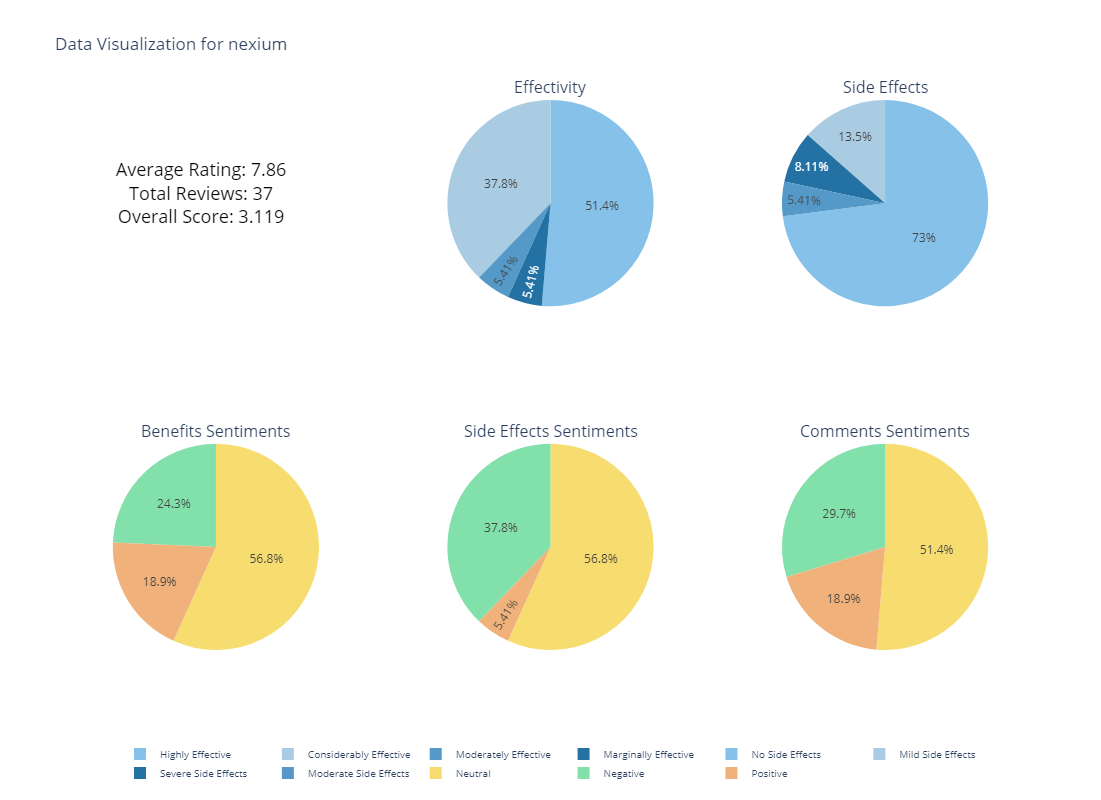

In [111]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from IPython.display import display, clear_output

df = pd.DataFrame(data)

# Map categorical values to numerical values
effectiveness_mapping = {
    'Highly Effective': 5,
    'Considerably Effective': 4,
    'Moderately Effective': 3,
    'Marginally Effective': 2,
    'Ineffective': 1
}

sideEffects_mapping = {
    'No Side Effects': 5,
    'Mild Side Effects': 4,
    'Moderate Side Effects': 3,
    'Severe Side Effects':2,
    'Extremely Severe Side Effects': 1
}

# Color scheme for Effectivity and Side Effects based on mapping
colors_effectivity = {effectiveness_mapping[key]: color for key, color in zip(effectiveness_mapping, ['#85c1e9', '#a9cce3', '#5499c7', '#2471a3', '#154360'])}
colors_sideEffects = {sideEffects_mapping[key]: color for key, color in zip(sideEffects_mapping, ['#85c1e9', '#a9cce3', '#5499c7', '#2471a3', '#154360'])}

# Function to create the subplot
def create_subplot(urlDrugName):
    filtered_df = df[df['urlDrugName'] == urlDrugName]

    # Calculate average rating and count of reviews
    avg_rating = filtered_df['rating'].mean()
    review_count = filtered_df.shape[0]
    # Filter the DataFrame where 'urlDrugName' matches the specified drug name
    filter = aggregated_features[aggregated_features['urlDrugName'] == urlDrugName]
    
    # Select the 'overall_score' column and convert to integer
    os = round(filter['overall_score'].astype(float).values[0],4)

    # Pie charts data preparation
    effectivity_counts = filtered_df['effectiveness'].value_counts()
    sideEffects_counts = filtered_df['sideEffects'].value_counts()
    benefits_counts = filtered_df['benefits_model2Label'].value_counts()
    sideEffects_model2_counts = filtered_df['sideEffects_model2Label'].value_counts()
    comments_model2_counts = filtered_df['comments_model2Label'].value_counts()

    fig_width = 1100  # Width of the whole figure
    fig_height = 800 
    # Color scheme for Effectivity and Side Effects
    colors_common = ['#a9cce3', '#85c1e9', '#5499c7', '#3498db','#2471a3']

    # Color scheme for label pie charts (positive, neutral, negative)
    colors_labels = ['#F7DC6F', '#82E0AA', 'F0B27A']

    # Creating subplots - Adjusted the grid and removed the first 'xy' plot as we are using an annotation card
    fig = make_subplots(rows=2, cols=3, specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}],
                                               [{'type': 'domain'}, {'type': 'domain'}, {'type': 'domain'}]],
                        subplot_titles=('','Effectivity', 'Side Effects', 'Benefits Sentiments', 'Side Effects Sentiments', 'Comments Sentiments'))

    # Card-like annotation for average rating and review count
    # Adjusted x and y to place the annotation in the first cell of the grid
    fig.add_annotation(text=f'Average Rating: {avg_rating:.2f}<br>Total Reviews: {review_count}<br>Overall Score: {os}',
                       x=0.035, y=0.9,
                       showarrow=False,
                       font=dict(size=18, color='black'),
                       align='center')
    
    # Sort the counts according to the mapping values for effectivity
    sorted_effectivity = sorted(effectivity_counts.items(), key=lambda x: effectiveness_mapping[x[0]], reverse=True)
    effectivity_labels, effectivity_values = zip(*sorted_effectivity)
    
    # Sort the counts according to the mapping values for side effects
    sorted_sideEffects = sorted(sideEffects_counts.items(), key=lambda x: sideEffects_mapping[x[0]], reverse=True)
    sideEffects_labels, sideEffects_values = zip(*sorted_sideEffects)
   
    # Define the color scheme for each category based on sorting
    effectivity_colors = [colors_effectivity[effectiveness_mapping[label]] for label in effectivity_labels]
    sideEffects_colors = [colors_sideEffects[sideEffects_mapping[label]] for label in sideEffects_labels]
    
     # Pie charts
    fig.add_trace(go.Pie(labels=effectivity_labels, values=effectivity_values, name='Effectivity', marker=dict(colors=effectivity_colors)), row=1, col=2)
    fig.add_trace(go.Pie(labels=sideEffects_labels, values=sideEffects_values, name='Side Effects', marker=dict(colors=sideEffects_colors)), row=1, col=3)
    fig.add_trace(go.Pie(labels=benefits_counts.index, values=benefits_counts.values, name='Benefits Sentiments',marker=dict(colors=colors_labels)), row=2, col=1)
    fig.add_trace(go.Pie(labels=sideEffects_model2_counts.index, values=sideEffects_model2_counts.values, name='Side Effects Sentiments',marker=dict(colors=colors_labels)), row=2, col=2)
    fig.add_trace(go.Pie(labels=comments_model2_counts.index, values=comments_model2_counts.values, name='Comments Sentiments',marker=dict(colors=colors_labels)), row=2, col=3)

    # Update the layout for better appearance
    fig.update_layout(title_text=f"Data Visualization for {urlDrugName}",legend=dict(
            orientation="h",
            xanchor="center",
            yanchor="bottom",
            x=0.5,
            y=-0.25,  # Adjust this value to move the legend up or down
            font=dict(size=10),  # Adjust font size to fit the items
        ),width=fig_width,height=fig_height)

    # Show figure
    fig.show()

# Example usage
urlDrugName = input("Enter the drug name: ")
create_subplot(urlDrugName)

##### Side Effect Awareness

Enter the drug name:  nexium


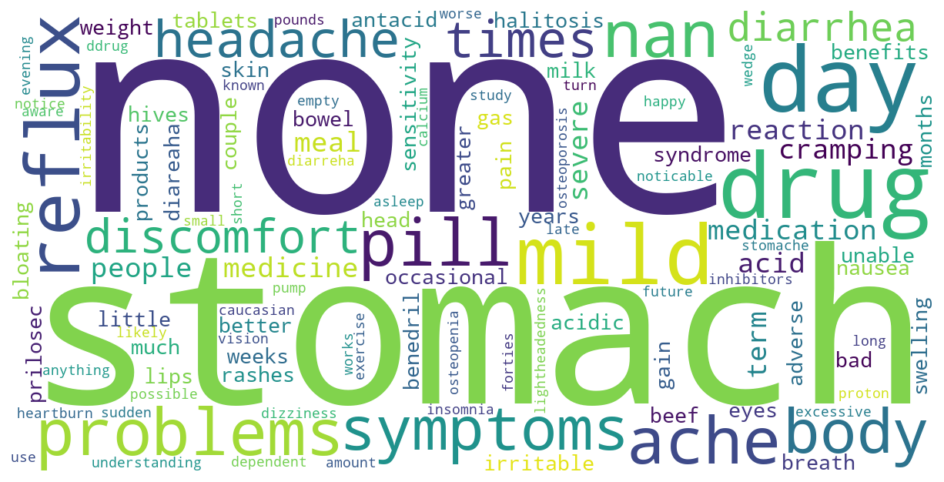

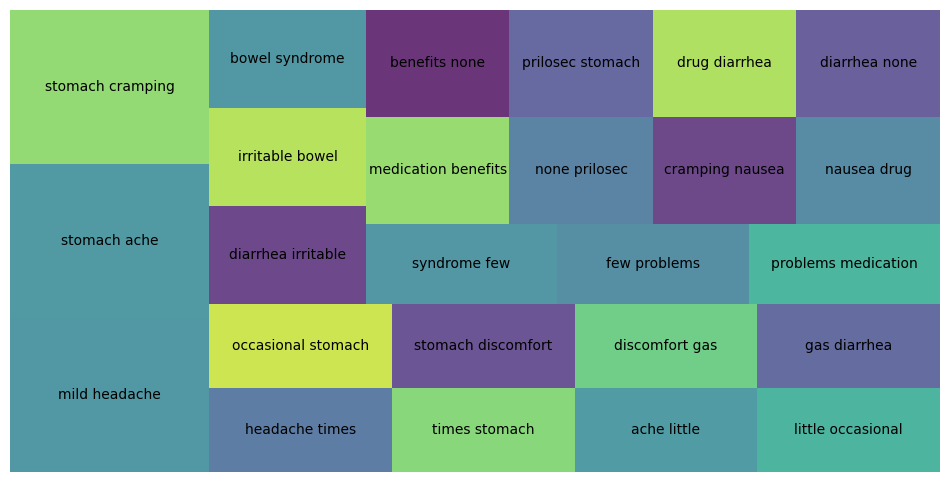

In [112]:
# User specifies the drug name
drugurlname = input("Enter the drug name: ")

# Assume 'df' is your DataFrame with 'urlDrugName' and 'sideEffectsReview' columns
# Filter reviews for the specified drug
drug_reviews = df[df['urlDrugName'].str.lower() == drugurlname.lower()]

# Function to keep only medically relevant terms
def filter_pos(text):
    tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    keep_tags = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS'}
    filtered_words = [word for word, tag in tagged if tag in keep_tags]
    return ' '.join(filtered_words)

# Apply the function to the filtered DataFrame
drug_reviews['filtered_review'] = drug_reviews['sideEffectsReview'].apply(lambda x: filter_pos(x.lower()))

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = " "+re.sub(r'\s+\b\w\b\s+', ' ', text)+" " # Remove single characters
    text = re.sub(r'\si\s', ' ', text) # Remove all the i's in the reviews
    text = re.sub(r'side effect?s?', '', text)  # Remove 'side effect' and 'side effects'
    text = re.sub(f'{drugurlname}?', '', text)  # Remove the drug name
    return text

# Preprocess the text
drug_reviews['processed_review'] = drug_reviews['filtered_review'].apply(preprocess_text)

# Generate a word cloud
wordcloud_text = ' '.join(drug_reviews['processed_review'])
wordcloud = WordCloud(width=1200, height=600, background_color ='white').generate(wordcloud_text)

# After displaying the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('C:/Users/Anishma/Research Project/wordcloud.png')  # Saves the word cloud image
plt.show()

# Generate and visualize n-grams (bigrams in this case)
all_reviews = ' '.join(drug_reviews['processed_review'])
tokens = word_tokenize(all_reviews)
bigrams = ngrams(tokens, 2)
bigram_freq = Counter(bigrams)

# Visualizing Bigrams using a Treemap
most_common_bigrams = bigram_freq.most_common(25)  # Increase number for treemap
bigram_labels = [' '.join(bigram) for bigram, freq in most_common_bigrams]
bigram_values = [freq for bigram, freq in most_common_bigrams]

# After displaying the treemap
plt.figure(figsize=(12, 6))
squarify.plot(sizes=bigram_values, label=bigram_labels, alpha=0.8)
plt.axis('off')
plt.savefig('C:/Users/Anishma/Research Project/treemap.png')  # Saves the treemap image
plt.show()

#### Exporting the Final Data

In [64]:
data.to_excel('data.xlsx',sheet_name="Data",index=False)